In [393]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm_notebook
from sys import argv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime

In [394]:
test_path = 'poker-hand-testing.data'
train_path = 'poker-hand-training-true.data'

In [395]:
def read_data(path):
    data = pd.read_csv(path, header=None)
    return data

In [396]:
train_data = read_data(train_path)
train_data

,0,1,2,3,4,5,6,7,8,9,10
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9
...,...,...,...,...,...,...,...,...,...,...,...
25005,3,9,2,6,4,11,4,12,2,4,0
25006,4,1,4,10,3,13,3,4,1,10,1
25007,2,1,2,10,4,4,4,1,4,13,1
25008,2,12,4,3,1,10,1,12,4,9,1


In [397]:
test_data = read_data(test_path)
test_data

,0,1,2,3,4,5,6,7,8,9,10
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0
...,...,...,...,...,...,...,...,...,...,...,...
999995,3,1,1,12,2,9,4,9,2,6,1
999996,3,3,4,5,2,7,1,4,4,3,1
999997,1,11,4,7,3,9,1,13,2,7,1
999998,3,11,1,8,1,1,3,13,2,8,1


In [398]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(train_data.iloc[:,:-1])

OneHotEncoder(handle_unknown='ignore')

In [399]:
X_train = ohe.transform(train_data.iloc[:,:-1]).toarray()
Y_train = np.array(train_data.iloc[:,-1])
print(X_train.shape, Y_train.shape)
print(type(X_train))
print('unique y:',np.unique(Y_train))

(25010, 85) (25010,)
<class 'numpy.ndarray'>
unique y: [0 1 2 3 4 5 6 7 8 9]


In [400]:
X_test = ohe.transform(test_data.iloc[:,:-1]).toarray()
Y_test = np.array(test_data.iloc[:,-1])
print(X_test.shape, Y_test.shape)
print('uniq y:', np.unique(Y_test))

(1000000, 85) (1000000,)
uniq y: [0 1 2 3 4 5 6 7 8 9]


In [499]:
class NN:
    def __init__(self, layers, feature_size = 85, target_class = 10, lr = 0.1, activation_m = 'sigmoid', lr_rate= 'normal'):
        self.hidden_layers = layers
        self.total_layers  = len(layers) + 1
        self.feature_size  = feature_size
        self.target_class  = target_class
        self.activation_m  = activation_m
        self.lr_rate = lr_rate
        self.lr      = lr
        self.params  = []
        self.layer_ip = [0]*self.total_layers
        self.layer_op = [0]*self.total_layers
        self.del_i = [0]*self.total_layers
        print('total layers: %d\n hidden_layers %s\n feature_size: %d'%(self.total_layers, str(self.hidden_layers), self.feature_size))
    
    def activation(self, X, typ = 'sigmoid'):
        if typ == 'sigmoid':
            return 1.0/(1.0 + np.exp(-X))
        else:
            return np.where(X<0,0,X)
        
    def softmax(self,X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis=1).reshape(-1,1)
    
    def derivative(self, X, typ = 'sigmoid'):
        if typ == 'sigmoid':
            return X*(1-X)
        elif typ == 'relu':
            return 1 * (X > 0)
    
    def initialize_params(self):
        total_layers = self.hidden_layers.copy()
        total_layers.append(self.target_class)
        layer_ip = self.feature_size
        #print('layers', total_layers)
        np.random.seed(0)
        #neurons_prev = self.feature_size
        for layer_no, layer_op in enumerate(total_layers):
            #print('Layers ip and op',layer_op, layer_ip)
            local_w = np.random.randn(layer_op, layer_ip)/np.sqrt(layer_ip)
            local_b = np.zeros((layer_op ,1))
            
            self.params.append([local_w, local_b])
            layer_ip = layer_op
        return
    
    def forward_pass(self, X):
        ip = X.copy()
        #print('Forward Pass')
        #print('data shape:', X.shape)
        #print('layers', self.total_layers)
        for layer_no in range(self.total_layers-1):
            
            [W, b] = self.params[layer_no].copy()
            #print('Params shapes:',W.shape, b.shape)
            
            H = 1.0*np.dot(ip, W.T) + b.T
            
            
            #print('H shape:', H.shape)
#             for i in range(H.shape[0]):
#                 for j in range(H.shape[1]):
#                     print(H[i,j], end = ' ' )
#                 print('', end = '\t')
            A = self.activation(H, self.activation_m)
            # Do we need to store the layers input and outputs as well?
            #print('A shape:', A.shape)
            self.layer_op[layer_no] = A.copy()
            self.layer_ip[layer_no] = ip.copy()
            ip = A
        
        #For OP Layer
        [W, b] = self.params[self.total_layers-1]
        #print('Params shapes:',W.shape, b.shape)
        H = 1.0*np.dot(ip, W.T) + b.T
        A = self.activation(H, 'sigmoid') #For OP only sigmoid
        self.layer_op[self.total_layers-1] = A.copy()
        self.layer_ip[self.total_layers-1] = ip.copy()
        #A = self.softmax(A)
        return A
    
    def back_propagation(self, Y):
        #print('---------------back propagation')
        m = Y.shape[0]
        l_op = self.layer_op[self.total_layers -1 ].copy()
        #print('l_op',l_op.shape)
        delZ = self.derivative(l_op, typ='sigmoid')
        #print('delZ',delZ.shape)
        #print('y',Y.shape)
        delJ_prev = (Y-l_op)*delZ/m
        self.del_i[self.total_layers-1] = delJ_prev.copy()
        #print('hidden layers rev',self.hidden_layers[::-1])
        
        #for layer_no in range(self.total_layers-1,0,-1):
        for ll_rev, nodes_count in enumerate(self.hidden_layers[::-1]):
            layer_no = self.total_layers -1- ll_rev
            #print(layer_no)
            #print('\tLayer:',layer_no, self.hidden_layers[layer_no])
            
            delO = self.derivative(self.layer_op[layer_no-1], self.activation_m).copy()
            #print('\tdelO', delO.shape)
            #print('\tdelJ_prev',delJ_prev.shape)
            #print('\tW_layer',self.params[layer_no][0].shape)
            #print('\tdelO',delO.shape)
            delJ_all = np.dot(delJ_prev, self.params[layer_no][0])* delO
            #print('\tdelJ_all',delJ_all.shape)
            
            self.del_i[layer_no-1] = delJ_all.copy()
            delJ_prev = delJ_all
            
        return None
    
    def cost_function(self, Y):
        return np.sum((Y - self.layer_op[self.total_layers-1])**2/(2*Y.shape[0]))
    
    def fit(self, X, y, lr=0.1, max_epochs=100, batch_size=100):
        ohe_y = OneHotEncoder(handle_unknown = 'ignore')
        ohe_y.fit(y.reshape(-1,1))
        Y     = ohe_y.transform(y.reshape(-1,1)).toarray()
        
        m     = X.shape[0]
        error = 0
        prev_error    = 0
        accuracy_list = []
        error_list    = []
        epochs_taken  = 0
        self.initialize_params()
        for epoch in tqdm_notebook(range(max_epochs)):
            batches = int(m/batch_size)
            error   = 0
            ind     = np.arange(m)
            np.random.shuffle(ind)
            #print('EPOCH NO------------:',epoch)
            for batch_no in range(batches):
                #print('batch no:',batch_no)
#                 pick_batch = ind[batch_no: batch_no + batch_size]
#                 X_b = X[pick_batch]
#                 Y_b = Y[pick_batch]
                #print('batch from -',batch_no*batch_size, (batch_no +1)*batch_size)
                X_b = X[batch_no*batch_size: (batch_no +1)*batch_size]
                Y_b = Y[batch_no*batch_size: (batch_no +1)*batch_size]
                #print('X_b',X_b.shape)
                #print('Y_b',Y_b.shape)
                
                self.forward_pass(X_b)
                self.back_propagation(Y_b)
                if self.lr_rate == 'adaptive':
                    lr = lr/math.sqrt(epoch+1)
                for layer_no in range(self.total_layers):
                    #print('del_i',self.del_i[layer_no].shape)
                    #print('layer_ip',self.layer_ip[layer_no].shape)
                    grad_W = np.dot(self.del_i[layer_no].T, self.layer_ip[layer_no])
                    grad_b = np.sum(self.del_i[layer_no], axis = 0).T.reshape((-1,1))
                    #print('lr:',lr)
                    #print('grad_W', grad_W.shape)
                    #print('param W',self.params[layer_no][0].shape)
                    self.params[layer_no][0] += lr*grad_W
                    self.params[layer_no][1] += lr*grad_b
                    error+= self.cost_function(Y_b)
                    
            error /=batch_size
#             self.forward_pass(X)
#             pred = self.layer_op[self.total_layers - 1]
#             pred = np.argmax(pred, axis = 1)
#             acc = accuracy_score(pred, y.reshape(-1))
#             accuracy_list.append(acc)
#             error_list.append(error)
            
            #print(pred.shape)
            
            #print('other acc',self.score(X,y))
            #print(y.shape)
            #print(pred.shape)
            #print('my acc', acc)
            #ohe_pred = ohe_y.transform(pred.reshape(-1,1)).toarray()
            #acc   = accuracy_score(ohe_pred, Y)
            
            #print('acc',acc)
            if abs(prev_error - error) < 0.000001:
                epochs_taken = epoch
                print('No significant updates, EXITTING ----------------------')
                break
            prev_error = error
            if epoch%100 == 1:
                self.forward_pass(X)
                pred = self.layer_op[self.total_layers - 1]
                pred = np.argmax(pred, axis = 1)
                acc = accuracy_score(pred, y.reshape(-1))
                accuracy_list.append(acc)
                error_list.append(error)
                print('epoch %-5d | error: %-6f | acc: %-10f'%(epoch, error, acc*100))
        print('Final Accuracy :',accuracy_list[-1])
        print('Final Error    :',error_list[-1])
        epochs_taken = max_epochs if epochs_taken == 0 else epochs_taken
        print('epochs taken   :',
        return accuracy_list, error_list
    
    def confusion_matrix(self, predictions, labels, plot_it = False, path = 'conf_matrix'):
        n = self.target_class
        conf_matrix = [[0 for i in range(n)] for j in range(n)]
        for p, l in zip(predictions, labels):
            conf_matrix[int(l)][int(p)] +=1
        if not plot_it:
            return conf_matrix
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.9)
        for i in range(len(conf_matrix)):
            for j in range(len(conf_matrix[0])):
                ax.text(x=j, y=i,s=conf_matrix[i][j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.plot()
        #plt.savefig(path)
        return conf_matrix
    
    def predict(self, X):
        pred = self.forward_pass(X)
        return np.argmax(pred, axis = 1)
        

In [500]:
%%time
nn_model = NN([25], lr_rate='normal')

total layers: 2
 hidden_layers [25]
 feature_size: 85
CPU times: user 164 µs, sys: 3 µs, total: 167 µs
Wall time: 141 µs


In [505]:
# ohe_y = OneHotEncoder(handle_unknown='ignore')
# ohe_y.fit(Y_train.reshape(-1,1))
# Y_train_ohe = ohe_y.transform(Y_train.reshape(-1,1)).toarray()
accuracy_list, error_list = nn_model.fit(X_train[:], Y_train[:], lr=0.1, max_epochs=1000)

/tmp/ipykernel_8193/2304490630.py:130: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(max_epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 1     | error: 1.418364 | acc: 49.964014 
epoch 101   | error: 1.417522 | acc: 49.960016 
epoch 201   | error: 1.417022 | acc: 50.155938 
epoch 301   | error: 1.416029 | acc: 50.211915 
epoch 401   | error: 1.412615 | acc: 50.695722 
epoch 501   | error: 1.396063 | acc: 53.126749 
epoch 601   | error: 1.360217 | acc: 56.077569 
epoch 701   | error: 1.324861 | acc: 58.412635 
epoch 801   | error: 1.290710 | acc: 60.231907 
epoch 901   | error: 1.251421 | acc: 62.682927 


0.6577369052379048


[[10225, 2268, 0, 0, 0, 0, 0, 0, 0, 0],
 [4374, 6225, 0, 0, 0, 0, 0, 0, 0, 0],
 [315, 891, 0, 0, 0, 0, 0, 0, 0, 0],
 [56, 457, 0, 0, 0, 0, 0, 0, 0, 0],
 [72, 21, 0, 0, 0, 0, 0, 0, 0, 0],
 [49, 5, 0, 0, 0, 0, 0, 0, 0, 0],
 [5, 31, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 6, 0, 0, 0, 0, 0, 0, 0, 0],
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

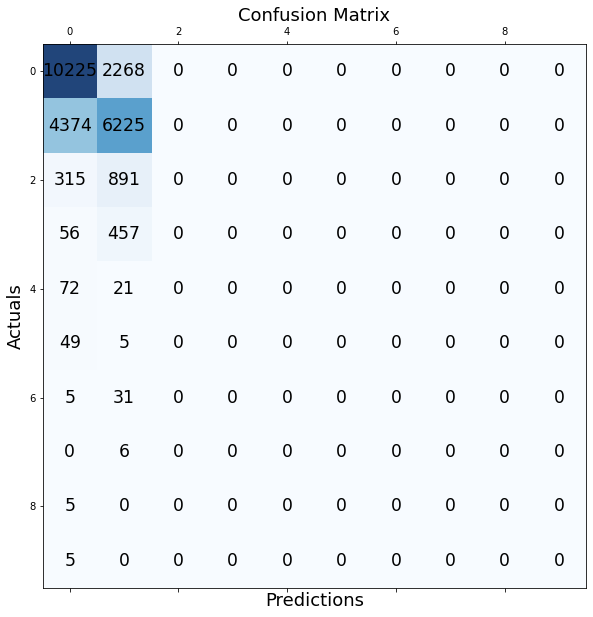

In [509]:
print('For Train data:')
prediction_train = nn_model.predict(X_train)
print('Acuracy:', accuracy_score(prediction_train, Y_train))
nn_model.confusion_matrix(predictions=prediction_train, labels=Y_train, plot_it=True)

For Test data:
Acuracy: 0.621587


[[393930, 107279, 0, 0, 0, 0, 0, 0, 0, 0],
 [194841, 227657, 0, 0, 0, 0, 0, 0, 0, 0],
 [12747, 34875, 0, 0, 0, 0, 0, 0, 0, 0],
 [2265, 18856, 0, 0, 0, 0, 0, 0, 0, 0],
 [2906, 979, 0, 0, 0, 0, 0, 0, 0, 0],
 [1832, 164, 0, 0, 0, 0, 0, 0, 0, 0],
 [93, 1331, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 229, 0, 0, 0, 0, 0, 0, 0, 0],
 [11, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

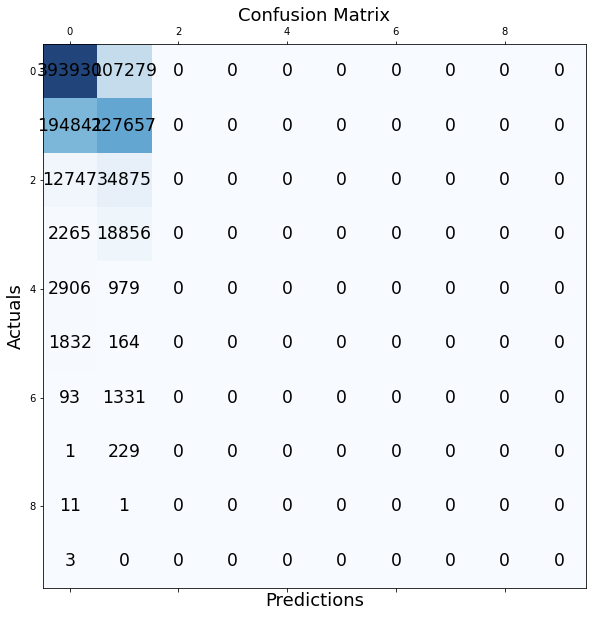

In [510]:
print('For Test data:')
prediction_test = nn_model.predict(X_test)
print('Acuracy:', accuracy_score(prediction_test, Y_test))
nn_model.confusion_matrix(predictions=prediction_test, labels=Y_test, plot_it=True)

In [506]:
y_df.value_counts()

0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        5
dtype: int64

In [507]:
y_df.describe()

,0
count,25010.000000
mean,0.621152
std,0.788361
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,9.000000


In [ ]:
pred = nn_model.forward_pass(X_train[:200])
pred = np.argmax(pred, axis=1)
ohe_pred = ohe_y.transform(pred.reshape(-1,1)).toarray()
print('ohe pred', ohe_pred.shape)
print('ohe y', Y_train_ohe[:200].shape)
acc1 = accuracy_score(ohe_pred, Y_train_ohe[:200])
acc2 = accuracy_score(pred, Y_train[:200])
print(acc1, acc2)

In [2]:
class FF_MultiClass_InputWeightVectorised:
  
  def __init__(self, W1, W2):
    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,4))
  
  def sigmoid(self, X):
    return 1.0/(1.0 + np.exp(-X))
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X):
    self.A1 = np.matmul(X,self.W1) + self.B1 # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.sigmoid(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2 # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
    
  def grad_sigmoid(self, X):
    return X*(1-X) 
  
  def grad(self, X, Y):
    self.forward_pass(X)
    m = X.shape[0]
    
    self.dA2 = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    
    self.dW2 = np.matmul(self.H1.T, self.dA2) # (2, N) * (N, 4) -> (2, 4)
    self.dB2 = np.sum(self.dA2, axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.dH1 = np.matmul(self.dA2, self.W2.T) # (N, 4) * (4, 2) -> (N, 2)
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    
    self.dW1 = np.matmul(X.T, self.dA1) # (2, N) * (N, 2) -> (2, 2)
    self.dB1 = np.sum(self.dA1, axis=0).reshape(1, -1) # (N, 2) -> (1, 2)

      
  def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False):
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      self.grad(X, Y) # X -> (N, 2), Y -> (N, 4)
        
      m = X.shape[0]
      self.W2 -= learning_rate * (self.dW2/m)
      self.B2 -= learning_rate * (self.dB2/m)
      self.W1 -= learning_rate * (self.dW1/m)
      self.B1 -= learning_rate * (self.dB1/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

None
